## Source code for _A statistical theory for optimal decision-making in sports betting_
### Jacek P. Dmochowski, (c) 2023

In [36]:
import glob, numpy as np, pandas as pd, os
import matplotlib.pyplot as plt, seaborn as sns
from sklearn.neighbors import KernelDensity
from sklearn.linear_model import LinearRegression

In [37]:
def get_conditional_cdf(df, key_cond, val_cond, key_metric, lb=-40, ub=40, n_points=4000, gaussian_bw=2, do_boot=False):

    if do_boot:
        data = df.loc[ df[key_cond] == val_cond, key_metric].sample(frac=1, replace=True)
    else:
        data = df.loc[ df[key_cond] == val_cond, key_metric]

    sample = np.atleast_2d(data).T
    kde = KernelDensity(kernel="gaussian", bandwidth=gaussian_bw).fit(sample)
    xx = np.atleast_2d(np.linspace(lb,ub,n_points)).T
    yy = kde.score_samples(xx)
    kde_cdf = np.cumsum(np.exp(yy)) / np.sum(np.exp(yy))

    return kde_cdf, xx, yy, sample

def get_quantiles_from_cdf(cdf,xx,yq):
    # xx is the entire cdf x axis
    # yq is a list of the quantiles that you want eg. [0.47,0.5,0.53]
    vals=[]
    inds=[]
    for q in yq:
        idx = np.argmin(np.abs(cdf-q))
        vals.append(xx[idx])
        inds.append(idx)
    return vals, inds

def my_ci(x):
    # return 95% confidence interval of vector x
    # x has been loaded with bootstrapped values, for example
    return (np.quantile(x,0.025), np.quantile(x,0.975))

def stylize_axes(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

#### Specify analysis "options"

In [38]:
root_data_folder = '/Users/jacekdmochowski/PROJECTS/margin/MARGIN/data/nfl/bettingdata/'
path_to_fig='/Users/jacekdmochowski/PROJECTS/margin/MARGIN/figures/'
odds_keystr='*odds*.csv'
NEGATE_SPREADS=True
key_spread='Consensus'
year_range = range(2002,2023)

In [39]:
n_boots=1000
offsets = [-3,-2,-1,0,1,2,3]
mincount=100
gaussian_bw=2
phi=100/110

In [40]:
odds_filenames=[]
for year in year_range:
    data_folder = os.path.join(root_data_folder,str(year))
    for filename in glob.iglob(os.path.join(data_folder,odds_keystr), recursive=True):
         odds_filenames.append(filename)
print("Found ", len(odds_filenames),  "odds csv files")

Found  363 odds csv files


In [41]:
dfo = pd.DataFrame({})
for fi in odds_filenames:
    dfo = pd.concat((dfo,pd.read_csv(fi)))

dfo=dfo.drop_duplicates()

In [42]:
if NEGATE_SPREADS:
    dfo['sportsbook_spread'] = -dfo.ConsensusHomePointSpread
else:
    dfo['sportsbook_spread'] = dfo.ConsensusHomePointSpread

dfo['sportsbook_total']  = dfo.ConsensusOverUnder

dfo['true_margin'] = dfo['HomeScore'] - dfo['AwayScore']

dfo['true_total'] = dfo['HomeScore'] + dfo['AwayScore']

print("Mean home point spread = " , dfo.sportsbook_spread.mean(), "+-" , dfo.sportsbook_spread.std() )
print("Mean total = " , dfo.sportsbook_total.mean(), "+-" , dfo.sportsbook_total.std())
print("Median home point spread = " , dfo.sportsbook_spread.median() )
print("Median total = " , dfo.sportsbook_total.median() )

print("Mean margin of victory = " , dfo.true_margin.mean(), "+-" , dfo.true_margin.std() )
print("Mean true total = " , dfo.true_total.mean(), "+-" , dfo.true_total.std())
print("Median margin of victory = " , dfo.true_margin.median() )
print("Median true total = " , dfo.true_total.median() )

Mean home point spread =  2.206918819188192 +- 5.972760498524986
Mean total =  43.79750922509225 +- 4.801773069647243
Median home point spread =  3.0
Median total =  44.0
Mean margin of victory =  2.192719881744272 +- 14.684421315728175
Mean true total =  44.43440502586844 +- 14.127738612277504
Median margin of victory =  3.0
Median true total =  44.0


In [43]:
dfo['has_nans'] = dfo.apply(lambda x: np.sum( np.isnan ( x['true_margin'] ) ) > 0 , axis=1 )
print(dfo['has_nans'].sum(), "nans detected")
dfo = dfo[dfo.has_nans==False]

8 nans detected


In [44]:
dfo.shape

(5412, 209)

In [45]:
unq_spreads = np.unique(dfo.sportsbook_spread)
unq_totals = np.unique(dfo.sportsbook_total)

## Build dataframe for analysis of margin of victory

In [46]:
kde_ev=np.nan * np.ones(shape=(len(unq_spreads),n_boots,len(offsets)))
dict_margin = [] # stores summary statistics: median + other quantiles
dict_margin_raw = [] # stores each record on its own dataframe row

for idx_s, spread in enumerate(unq_spreads):

    for b in range(n_boots):
        kde_cdf, xx, yy, sample = get_conditional_cdf(dfo,'sportsbook_spread',spread,'true_margin',-40,40,4000,gaussian_bw, do_boot=True)

        tvals,tinds = get_quantiles_from_cdf(kde_cdf,xx,[phi/(1+phi),0.5,1/(1+phi)])

        # measure expected value as a function of offset
        # now across bootstrap samples
        for idx_o,offset in enumerate(offsets):
            tidx = np.argmin(np.abs(xx - (xx[tinds[1]] + offset)))
            Fmm = kde_cdf[tidx]
            ev_bh = Fmm*phi - (1-Fmm)
            ev_bv = (1-Fmm)*phi - Fmm
            ev_max = np.max((ev_bh,ev_bv))
            kde_ev[idx_s,b,idx_o] = ev_max

            dict_margin_raw.append(
            {
                'idx_offset':tidx,
                'offset': offset,
                'bootidx': b,
                'spread': spread,
                'ev': ev_max
            }
            )

        dict_margin.append(
            {
                'q47': tvals[0][0],
                'median': tvals[1][0],
                'q53': tvals[2][0],
                'count': np.sum(dfo['sportsbook_spread']==spread),
                'spread': spread,
                'ev': kde_ev[idx_s,b,:],
                'bootidx': b
            }
        )

df_margin = pd.DataFrame(dict_margin)
df_margin=df_margin.set_index('spread')

df_margin_raw = pd.DataFrame(dict_margin_raw)

#### Split ev column into series

In [47]:
df_tmp = df_margin.ev.apply(pd.Series)
df_tmp.columns = ['-3','-2','-1','0','1','2','3']
df_margin=pd.concat((df_margin,df_tmp),axis=1)
df_margin=df_margin.drop('ev',axis=1)

for key,val in df_margin.items():
        try:
            df_margin[key]=df_margin[key].str[0]
        except:
            pass

## Build dataframe for analysis of totals

In [48]:
kde_total_ev=np.nan * np.ones(shape=(len(unq_totals),n_boots,len(offsets)))
dict_total = []
dict_total_raw = []

for idx_t, total in enumerate(unq_totals):

    for b in range(n_boots):
        kde_cdf, xx, yy, _ = get_conditional_cdf(dfo,'sportsbook_total',total,'true_total',10,90,4000,gaussian_bw, do_boot=True)
        tvals,tinds = get_quantiles_from_cdf(kde_cdf,xx,[0.47,0.5,0.53])

        for idx_o,offset in enumerate(offsets):
            tidx = np.argmin(np.abs(xx - (xx[tinds[1]] + offset)))
            Fmm = kde_cdf[tidx]
            ev_bo = Fmm*phi - (1-Fmm)
            ev_bu = (1-Fmm)*phi - Fmm
            ev_max = np.max((ev_bo,ev_bu))
            kde_total_ev[idx_t,b,idx_o] = ev_max

            dict_total_raw.append(
            {
                'idx_offset':tidx,
                'offset': offset,
                'bootidx': b,
                'total': total,
                'ev': ev_max
            }
            )

        dict_total.append(
            {
                'q47': tvals[0],
                'median': tvals[1],
                'q53': tvals[2],
                'count': np.sum(dfo['sportsbook_total']==total),
                'total': total,
                'ev': kde_total_ev[idx_t,b,:],
                'bootidx': b
            }
        )
df_total = pd.DataFrame(dict_total)
df_total = df_total.set_index('total')

df_total_raw = pd.DataFrame(dict_total_raw)

In [49]:
df_tmp = df_total.ev.apply(pd.Series)
df_tmp.columns = ['-3','-2','-1','0','1','2','3']
df_total=pd.concat((df_total,df_tmp),axis=1)
df_total = df_total.drop('ev',axis=1)

for key,val in df_total.items():
    try:
        df_total[key]=df_total[key].str[0]
    except:
        pass

total_rows_to_show= (df_total['count']>mincount)
total_n_to_show=np.sum(total_rows_to_show)

#### Identify stratifications with sufficient data

In [50]:
has_enough_samples_margin = df_margin['count']>mincount
valid_spreads = np.unique(df_margin[has_enough_samples_margin].index)

has_enough_samples_total = df_total['count']>mincount
valid_totals = np.unique(df_total[has_enough_samples_total].index)

#### Construct confidence intervals for margin data

In [51]:
df_margin_ci = df_margin.loc[:,['q47','median','q53','-3','-2','-1','0','1','2','3']].groupby('spread').quantile((0.025,0.975))
df_margin_ci = df_margin_ci.loc[valid_spreads,:]
df_margin_ci['is_below_47'] = df_margin_ci.apply(lambda x: x['q47'] > x.name[0] if x.name[1]==0.025 else False, axis=1 )
df_margin_ci['is_above_53'] = df_margin_ci.apply(lambda x: x['q53'] < x.name[0] if x.name[1]==0.975 else False, axis=1 )
df_margin_ci['is_sig'] = df_margin_ci['is_below_47'] | df_margin_ci['is_above_53']

In [52]:
df_margin_ci_lo = df_margin_ci.loc[df_margin_ci.index.get_level_values(None) == 0.025,:]
df_margin_ci_hi = df_margin_ci.loc[df_margin_ci.index.get_level_values(None) == 0.975,:]

ci_width_47_m = df_margin_ci.loc[df_margin_ci.index.get_level_values(None) == 0.975,'q47'].to_numpy() - df_margin_ci.loc[df_margin_ci.index.get_level_values(None) == 0.025,'q47'].to_numpy()

ci_width_53_m = df_margin_ci.loc[df_margin_ci.index.get_level_values(None) == 0.975,'q53'].to_numpy() - df_margin_ci.loc[df_margin_ci.index.get_level_values(None) == 0.025,'q53'].to_numpy()

#### Construct confidence intervals for total dataframe

In [53]:
df_total_ci = df_total.loc[:,['q47','median','q53','-3','-2','-1','0','1','2','3']].groupby('total').quantile((0.025,0.975))
df_total_ci = df_total_ci.loc[valid_totals,:]
df_total_ci['is_below_47'] = df_total_ci.apply(lambda x: x['q47'] > x.name[0] if x.name[1]==0.025 else False, axis=1 )
df_total_ci['is_above_53'] = df_total_ci.apply(lambda x: x['q53'] < x.name[0] if x.name[1]==0.975 else False, axis=1 )
df_total_ci['is_sig'] = df_total_ci['is_below_47'] | df_total_ci['is_above_53']

In [54]:
df_total_ci_lo = df_total_ci.loc[df_total_ci.index.get_level_values(None) == 0.025,:]
df_total_ci_hi = df_total_ci.loc[df_total_ci.index.get_level_values(None) == 0.975,:]

ci_width_47_t = df_total_ci.loc[df_total_ci.index.get_level_values(None) == 0.975,'q47'].to_numpy() - df_total_ci.loc[df_total_ci.index.get_level_values(None) == 0.025,'q47'].to_numpy()

ci_width_53_t = df_total_ci.loc[df_total_ci.index.get_level_values(None) == 0.975,'q53'].to_numpy() - df_total_ci.loc[df_total_ci.index.get_level_values(None) == 0.025,'q53'].to_numpy()

#### Measure the correlation between median outcome and the sportsbook spread

In [55]:
df_margin = df_margin.reset_index()

df_group = df_margin[df_margin.spread.isin(valid_spreads)].groupby('bootidx')['spread', 'median']
df_margin_reg = pd.DataFrame()
for group in df_group.groups.keys():
    df = df_group.get_group(group)
    X = np.array(df[['spread']])
    y = np.array(df[['median']])
    model = LinearRegression().fit(X, y)
    df_margin_reg.loc[group, ['slope']] = model.coef_[0][0]
    df_margin_reg.loc[group, ['intercept']] = model.intercept_[0]
    df_margin_reg.loc[group, ['r2']] = model.score(X, y)

df_margin_reg_mean = df_margin_reg.mean(axis=0)
df_margin_reg_lo = df_margin_reg.quantile(0.025)
df_margin_reg_hi = df_margin_reg.quantile(0.975)

a_m = df_margin_reg_mean['slope']
b_m = df_margin_reg_mean['intercept']
r_squared_m = df_margin_reg_mean['r2']

df_margin=df_margin.set_index('spread')

/var/folders/rr/jrb2ds1j2pj23dsv9x3lk9y00000gn/T/ipykernel_9540/2590896136.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_group = df_margin[df_margin.spread.isin(valid_spreads)].groupby('bootidx')['spread', 'median']


#### Measure the correlation between median total and sportsbook total

In [56]:
df_total = df_total.reset_index()

df_group = df_total[df_total.total.isin(valid_totals)].groupby('bootidx')['total', 'median']
df_total_reg = pd.DataFrame()
for group in df_group.groups.keys():
    df = df_group.get_group(group)
    X = np.array(df[['total']])
    y = np.array(df[['median']])
    model = LinearRegression().fit(X, y)
    df_total_reg.loc[group, ['slope']] = model.coef_[0][0]
    df_total_reg.loc[group, ['intercept']] = model.intercept_[0]
    df_total_reg.loc[group, ['r2']] = model.score(X, y)

df_total_reg_mean = df_total_reg.mean(axis=0)
df_total_reg_lo = df_total_reg.quantile(0.025)
df_total_reg_hi = df_total_reg.quantile(0.975)

a_t = df_total_reg_mean['slope']
b_t = df_total_reg_mean['intercept']
r_squared_t = df_total_reg_mean['r2']

a_t, b_t, r_squared_t

df_total = df_total.set_index('total')

/var/folders/rr/jrb2ds1j2pj23dsv9x3lk9y00000gn/T/ipykernel_9540/733984102.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_group = df_total[df_total.total.isin(valid_totals)].groupby('bootidx')['total', 'median']


## Construct a dataframe for housing the average values across bootstraps

In [57]:
df_margin_mu = df_margin.loc[valid_spreads,['q47','median','q53','-3','-2','-1','0','1','2','3']].groupby('spread').mean()
df_total_mu = df_total.loc[valid_totals,['q47','median','q53','-3','-2','-1','0','1','2','3']].groupby('total').mean()

#### Combine mean and confidence interval data

In [58]:
df_margin_mu['level'] = 'Mean'
df_margin_mu.set_index('level', append=True, inplace=True)
df_margin_cat = pd.concat((df_margin_mu,df_margin_ci),axis=0)
df_margin_cat=df_margin_cat.sort_index()

In [59]:
df_total_mu['level'] = 'Mean'
df_total_mu.set_index('level', append=True, inplace=True)
df_total_cat = pd.concat((df_total_mu,df_total_ci),axis=0)
df_total_cat=df_total_cat.sort_index()

#### Get the grand average of the data

In [60]:
grand_mus_margin = df_margin_mu.mean(axis=0)
grand_sigmas_margin = df_margin_mu.std(axis=0)

In [61]:
grand_mus_total = df_total_mu.mean(axis=0)
grand_sigmas_total = df_total_mu.std(axis=0)

#### Filter the "raw" dataframes (containing results of each bootstrap)

In [62]:
df_margin_raw_filt = df_margin_raw.loc[df_margin_raw.spread.isin(valid_spreads),:]
df_total_raw_filt = df_total_raw.loc[df_total_raw.total.isin(valid_totals),:]

## Figures begin here

#### Figure 1
#### Median margin vs spread, median total vs sportsbook total

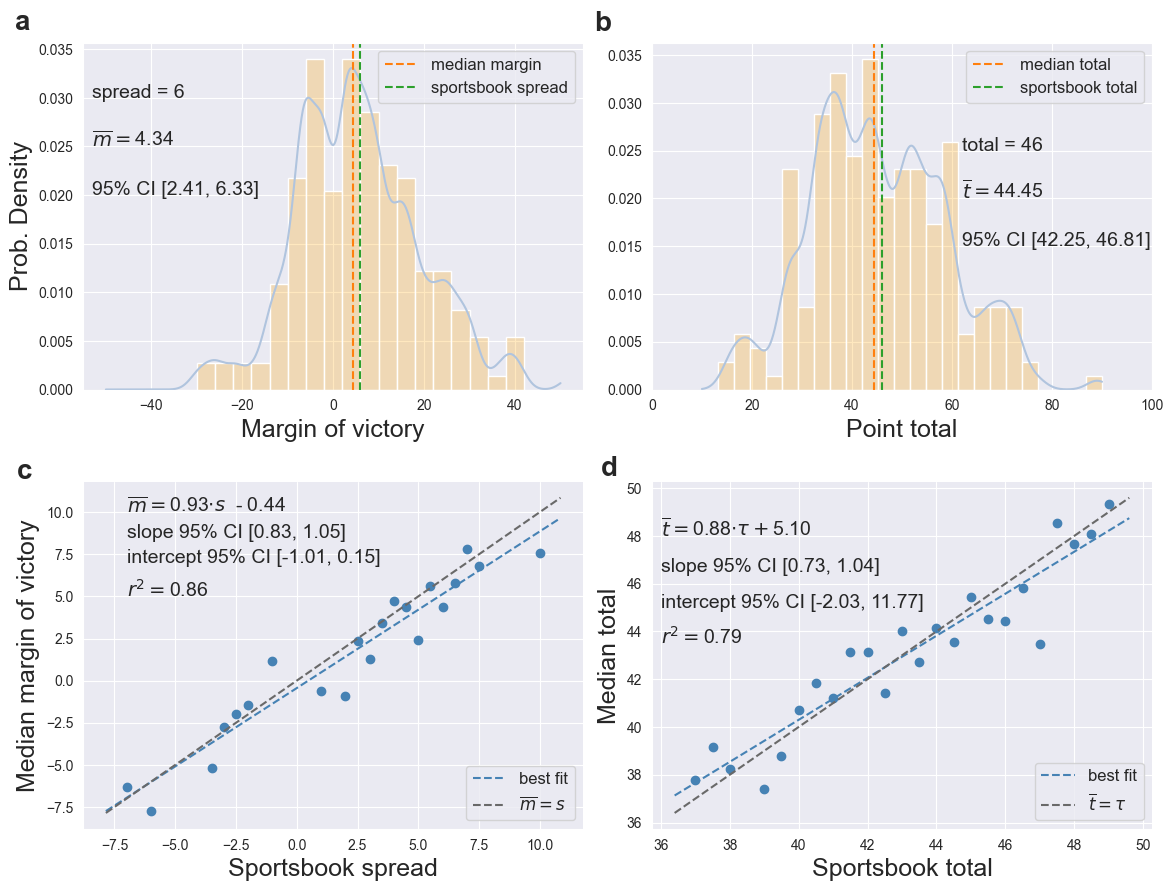

In [87]:
# data for kde plot of one stratified sample of margins (here so=6)
so=6
mdnm=df_margin_mu.loc[so,'median'].to_numpy()[0]
kde_cdfm, xxm, yym, smpm = get_conditional_cdf(dfo,'sportsbook_spread',so,'true_margin',-50,50,5000,gaussian_bw)

# data for kde plot of one stratified sample of totals
to=46
mdnt=df_total_mu.loc[to,'median'].to_numpy()[0]
kde_cdft, xxt, yyt, smpt = get_conditional_cdf(dfo,'sportsbook_total',to,'true_total',10,90,5000,gaussian_bw)

lgfs=12

fig,ax = plt.subplots(2,2,figsize=(12,9))
ax[0,0].plot(xxm,np.exp(yym),color='lightsteelblue')
ax[0,0].hist(smpm,bins=25,density=True,range=[-50,50],fc=(255/255,165/255,0/255,0.25))
#fc=(255/255,87/255,51/255,0.25)
yl=ax[0,0].get_ylim()
ax[0,0].plot([mdnm, mdnm],yl, label='median margin', ls='--')
ax[0,0].plot([so, so],yl, label='sportsbook spread', ls='--')
ax[0,0].legend(loc='upper right',fontsize=lgfs)
ax[0,0].set_ylim(yl)
ax[0,0].set_ylabel('Prob. Density', fontdict={'family':'sans-serif','size':18})
ax[0,0].set_xlabel('Margin of victory', fontdict={'family':'sans-serif','size':18})
ax[0,0].text(-53, 0.025, '$\overline{m} = $' + "{:.2f}".format(mdnm)  , fontsize = 14)
ax[0,0].text(-53, 0.03, 'spread = ' + "{:.0f}".format(so), fontsize = 14)
ax[0,0].text(-53, 0.02, '95% CI [' + "{:.2f}".format(df_margin_ci.loc[(so,0.025),'median'])
             + ", {:.2f}".format(df_margin_ci.loc[(so,0.975),'median']) + ']', fontsize = 14)
ax[0,0].text(-70,0.037,'a', fontdict={'family':'sans-serif','size':20,'weight':'bold'} )

ax[0,1].plot(xxt,np.exp(yyt),color='lightsteelblue')
ax[0,1].hist(smpt,bins=25,density=True,range=[10,90],fc=(255/255,165/255,0/255,0.25))
yl=ax[0,1].get_ylim()
ax[0,1].plot([mdnt, mdnt],yl, label='median total', ls='--')
ax[0,1].plot([to, to],yl, label='sportsbook total', ls='--')
ax[0,1].legend(loc='upper right', fontsize=lgfs)
ax[0,1].set_ylim(yl)
ax[0,1].set_xlim((0,100))
#ax[0,1].set_ylabel('Prob. Density', fontdict={'family':'sans-serif','size':18})
ax[0,1].set_xlabel('Point total', fontdict={'family':'sans-serif','size':18})
ax[0,1].text(62, 0.025, r'total = ' + "{:.0f}".format(to), fontsize = 14)
ax[0,1].text(62, 0.02, '$\overline{t} = $' + "{:.2f}".format(mdnt)  , fontsize = 14)
ax[0,1].text(62, 0.015, '95% CI [' + "{:.2f}".format(df_total_ci.loc[(to,0.025),'median'])
             + ", {:.2f}".format(df_total_ci.loc[(to,0.975),'median']) + ']', fontsize = 14)
ax[0,1].text(-11.5,0.0375,'b', fontdict={'family':'sans-serif','size':20,'weight':'bold'} )


ax[1,0].plot(valid_spreads,df_margin_mu['median'],'o',color='steelblue')
xax = np.array(ax[1,0].get_xlim())
ax[1,0].plot(xax, a_m*xax+b_m,'--',color='steelblue', label='best fit')
ax[1,0].plot(xax, xax,'--',color='dimgray', label='$\overline{m}=s$')
stylize_axes(ax[1,0])
ax[1,0].set_ylabel('Median margin of victory', fontdict={'family':'sans-serif','size':18})
ax[1,0].set_xlabel('Sportsbook spread', fontdict={'family':'sans-serif','size':18})
ax[1,0].text(-7, 10, '$\overline{m} = $' + "{:.2f}".format(a_m) + "$\cdot s$  - {:.2f}".format(np.abs(b_m))  , fontsize = 14)

ax[1,0].text(-7, 8.5, 'slope 95% CI [' + "{:.2f}".format(df_margin_reg_lo['slope'] )
             + ", {:.2f}".format(df_margin_reg_hi['slope']) + ']', fontsize = 14)
ax[1,0].text(-7, 7, 'intercept 95% CI [' + "{:.2f}".format(df_margin_reg_lo['intercept'] )
             + ", {:.2f}".format(df_margin_reg_hi['intercept']) + ']', fontsize = 14)

ax[1,0].text(-7, 5, '$r^2 = $' + "{:.2f}".format(r_squared_m), fontsize = 14)

ax[1,0].legend(loc='lower right',fontsize=lgfs)
ax[1,0].text(-11.5,12,'c', fontdict={'family':'sans-serif','size':20,'weight':'bold'} )

ax[1,1].plot(valid_totals,df_total_mu['median'],'o',color='steelblue')
xax = np.array(ax[1,1].get_xlim())
ax[1,1].plot(xax, a_t*xax+b_t,'--',color='steelblue', label='best fit')
ax[1,1].plot(xax, xax,'--',color='dimgray', label='$\overline{t}= $' +  r'$\tau$')
stylize_axes(ax[1,1])
ax[1,1].set_ylabel('Median total', fontdict={'family':'sans-serif','size':18})
ax[1,1].set_xlabel('Sportsbook total', fontdict={'family':'sans-serif','size':18})
ax[1,1].text(36, 48, '$\overline{t} = $' + "{:.2f}".format(a_t) + '$\cdot$' + r'$\tau + $' + "{:.2f}".format(np.abs(b_t))  , fontsize = 14)

ax[1,1].text(36, 46.5, 'slope 95% CI [' + "{:.2f}".format(df_total_reg_lo['slope'] )
             + ", {:.2f}".format(df_total_reg_hi['slope']) + ']', fontsize = 14)
ax[1,1].text(36, 45, 'intercept 95% CI [' + "{:.2f}".format(df_total_reg_lo['intercept'] )
             + ", {:.2f}".format(df_total_reg_hi['intercept']) + ']', fontsize = 14)

ax[1,1].text(36, 43.5, '$r^2 = $' + "{:.2f}".format(r_squared_t), fontsize = 14)
ax[1,1].legend(loc='lower right',fontsize=lgfs)
ax[1,1].text(34.25,50.5,'d', fontdict={'family':'sans-serif','size':20,'weight':'bold'} )

fig.tight_layout()
plt.show()
fig.savefig(path_to_fig+'median_vs_spread.png', dpi=300, bbox_inches='tight', transparent=False)

#### Figure 2
#### Sportsbook spread versus 47-53 quantiles of actual spread

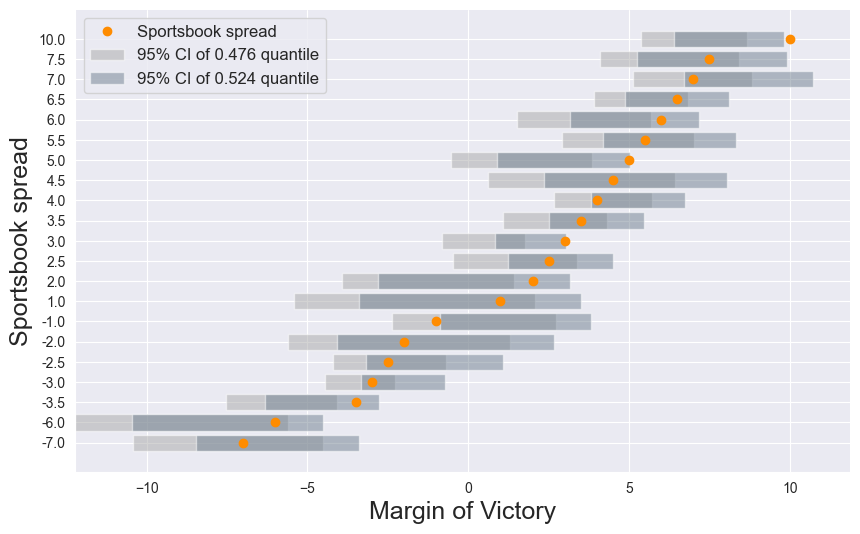

In [64]:
fig, ax = plt.subplots(1,figsize=(10,6))

xticks = np.arange(len(valid_spreads))
xticklabels = valid_spreads

# show 95% CI for 47th percentile (percentiles of percentiles!)
hb_47=ax.barh(xticks, ci_width_47_m, left=df_margin_ci_lo['q47'], color='darkgrey', label='95% CI of 0.476 quantile', alpha=0.5)
hb_53=ax.barh(xticks, ci_width_53_m, left=df_margin_ci_lo['q53'], color='slategrey', label='95% CI of 0.524 quantile', alpha=0.5)
hp=ax.plot(valid_spreads,xticks,'o', label='Sportsbook spread', color='darkorange')
xtck=ax.get_xticks()
ax.set_yticks(xticks)
ax.set_yticklabels(xticklabels)
stylize_axes(ax)
ax.set_ylabel('Sportsbook spread', fontdict={'family':'sans-serif','size':18})
ax.set_xlabel('Margin of Victory', fontdict={'family':'sans-serif','size':18})
ax.legend(fontsize=lgfs)
#ax.text(-10.5,19.5,'a', fontdict={'family':'sans-serif','size':20,'weight':'bold'} )

plt.show()
fig.tight_layout()
fig.savefig(path_to_fig+'vegas_vs_4753_spread.png', dpi=300, bbox_inches='tight', transparent=False)

#### Figure 3
#### Sportsbook total versus 47-53 quantiles of actual total

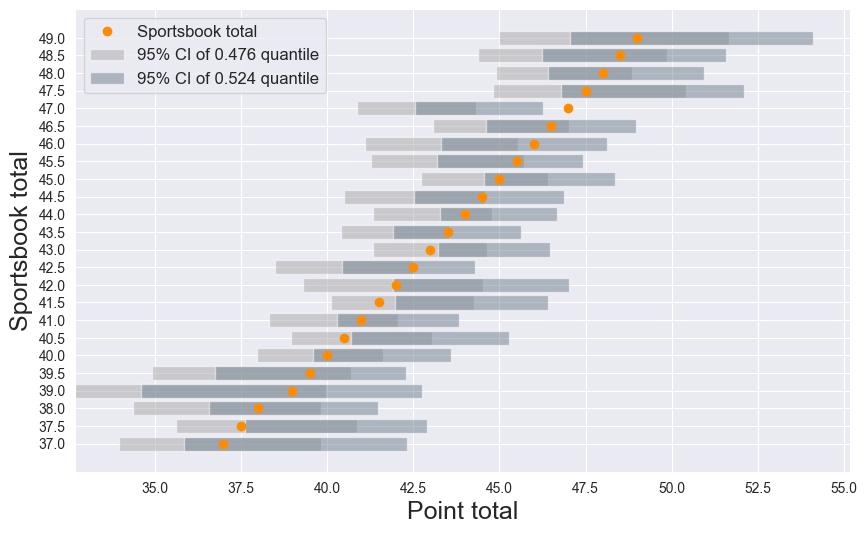

In [65]:
fig, ax = plt.subplots(1,figsize=(10,6))

xticks = np.arange(len(valid_totals))
xticklabels = valid_totals

# show 95% CI for 47th percentile (percentiles of percentiles!)
hb_47=ax.barh(xticks, ci_width_47_t, left=df_total_ci_lo['q47'], color='darkgrey', label='95% CI of 0.476 quantile', alpha=0.5)
hb_53=ax.barh(xticks, ci_width_53_t, left=df_total_ci_lo['q53'], color='slategrey', label='95% CI of 0.524 quantile', alpha=0.5)
hp=ax.plot(valid_totals,xticks,'o', label='Sportsbook total', color='darkorange')
xtck=ax.get_xticks()
ax.set_yticks(xticks)
ax.set_yticklabels(xticklabels)
stylize_axes(ax)
ax.set_ylabel('Sportsbook total', fontdict={'family':'sans-serif','size':18})
ax.set_xlabel('Point total', fontdict={'family':'sans-serif','size':18})
ax.legend(fontsize=lgfs)
#ax.text(-10.5,19.5,'a', fontdict={'family':'sans-serif','size':20,'weight':'bold'} )

plt.show()
fig.tight_layout()
fig.savefig(path_to_fig+'vegas_vs_4753_total.png', dpi=300, bbox_inches='tight', transparent=False)

#### Figure 4
#### Expected value as a function of the error in the sportsbook spread

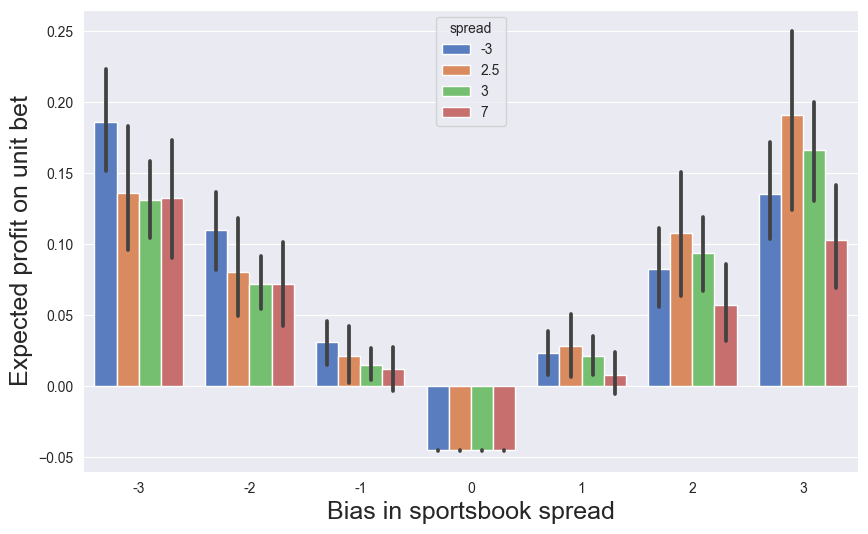

In [66]:
fig, ax = plt.subplots(1,figsize=(10,6))
ax=sns.barplot(data=df_margin_raw_filt, x="offset", y="ev", hue="spread", hue_order=[-3,2.5,3,7], errorbar=my_ci, palette="muted")

ax.set_xlabel('Bias in sportsbook spread', fontdict={'family':'sans-serif','size':18})
ax.set_ylabel('Expected profit on unit bet', fontdict={'family':'sans-serif','size':18})

fig.savefig(path_to_fig+'spread_vs_npoints_deviation.png', dpi=300, bbox_inches='tight', transparent=False)

#### Figure 5
#### Expected value as a function of the error in the sportsbook spread

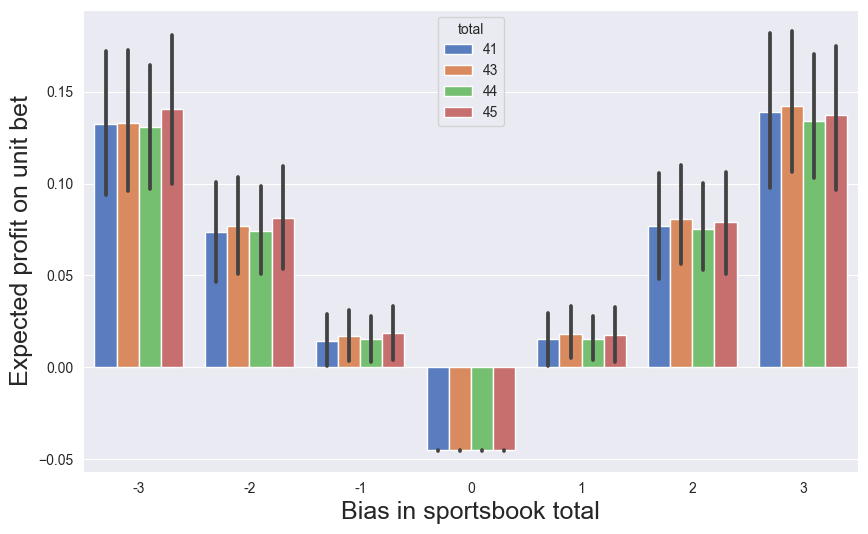

In [67]:
fig, ax = plt.subplots(1,figsize=(10,6))

ax=sns.barplot(data=df_total_raw_filt, x="offset", y="ev", hue="total", hue_order=[41,43,44,45], errorbar=my_ci, palette="muted")

ax.set_xlabel('Bias in sportsbook total', fontdict={'family':'sans-serif','size':18})
ax.set_ylabel('Expected profit on unit bet', fontdict={'family':'sans-serif','size':18})
fig.savefig(path_to_fig+'total_vs_npoints_deviation.png', dpi=300, bbox_inches='tight', transparent=False)

## Generate latex code for data tables

In [68]:
print(df_margin_cat.loc[:,['q47','median','q53','-3','-2','-1','0','1','2','3']].to_latex(index=True, float_format="%.3f", bold_rows=True))

\begin{tabular}{llrrrrrrrrrr}
\toprule
      &      &     q47 &  median &     q53 &    -3 &     -2 &     -1 &      0 &      1 &      2 &     3 \\
\textbf{spread} & \textbf{level} &         &         &         &       &        &        &        &        &        &       \\
\midrule
\textbf{-7.0 } & \textbf{0.025} & -10.433 &  -9.473 &  -8.453 & 0.056 &  0.024 & -0.011 & -0.045 & -0.008 &  0.032 & 0.079 \\
      & \textbf{0.975} &  -4.511 &  -3.891 &  -3.390 & 0.183 &  0.117 &  0.041 & -0.045 &  0.050 &  0.150 & 0.245 \\
      & \textbf{Mean} &  -7.123 &  -6.303 &  -5.547 & 0.112 &  0.065 &  0.012 & -0.045 &  0.019 &  0.088 & 0.161 \\
\textbf{-6.0 } & \textbf{0.025} & -12.214 & -11.314 & -10.453 & 0.056 &  0.023 & -0.011 & -0.045 & -0.009 &  0.028 & 0.066 \\
      & \textbf{0.975} &  -5.591 &  -5.031 &  -4.511 & 0.176 &  0.114 &  0.041 & -0.045 &  0.056 &  0.167 & 0.279 \\
      & \textbf{Mean} &  -8.577 &  -7.726 &  -6.933 & 0.111 &  0.062 &  0.010 & -0.045 &  0.017 &  0.086 & 0.163 \\


/var/folders/rr/jrb2ds1j2pj23dsv9x3lk9y00000gn/T/ipykernel_9540/3803130182.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df_margin_cat.loc[:,['q47','median','q53','-3','-2','-1','0','1','2','3']].to_latex(index=True, float_format="%.3f", bold_rows=True))


In [69]:
print(df_total_cat.loc[:,['q47','median','q53','-3','-2','-1','0','1','2','3']].to_latex(index=True, float_format="%.3f", bold_rows=True))

\begin{tabular}{llrrrrrrrrrr}
\toprule
     &      &    q47 &  median &    q53 &    -3 &    -2 &     -1 &      0 &      1 &     2 &     3 \\
\textbf{total} & \textbf{level} &        &         &        &       &       &        &        &        &       &       \\
\midrule
\textbf{37.0} & \textbf{0.025} & 33.966 &  34.866 & 35.846 & 0.057 & 0.020 & -0.013 & -0.045 & -0.013 & 0.019 & 0.051 \\
     & \textbf{0.975} & 39.828 &  41.109 & 42.328 & 0.176 & 0.102 &  0.026 & -0.045 &  0.021 & 0.083 & 0.145 \\
     & \textbf{Mean} & 36.602 &  37.761 & 38.992 & 0.115 & 0.060 &  0.006 & -0.045 &  0.003 & 0.049 & 0.094 \\
\textbf{37.5} & \textbf{0.025} & 35.624 &  36.647 & 37.626 & 0.080 & 0.037 & -0.005 & -0.045 & -0.004 & 0.037 & 0.076 \\
     & \textbf{0.975} & 40.869 &  41.888 & 42.908 & 0.189 & 0.113 &  0.035 & -0.045 &  0.032 & 0.106 & 0.176 \\
     & \textbf{Mean} & 38.169 &  39.153 & 40.154 & 0.132 & 0.074 &  0.014 & -0.045 &  0.013 & 0.070 & 0.125 \\
\textbf{38.0} & \textbf{0.025} & 34.386 

/var/folders/rr/jrb2ds1j2pj23dsv9x3lk9y00000gn/T/ipykernel_9540/937418051.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df_total_cat.loc[:,['q47','median','q53','-3','-2','-1','0','1','2','3']].to_latex(index=True, float_format="%.3f", bold_rows=True))


df_margin_ci

In [70]:
df_margin_ci

q47     median        q53        -3        -2        -1  \
spread                                                                        
-7.0   0.025 -10.432608  -9.473368  -8.453113  0.056288  0.023630 -0.010564   
       0.975  -4.511128  -3.890973  -3.390348  0.182881  0.117461  0.040709   
-6.0   0.025 -12.214054 -11.313828 -10.452613  0.055917  0.023415 -0.011165   
       0.975  -5.590898  -5.030758  -4.510628  0.176339  0.113642  0.040951   
-3.5   0.025  -7.532883  -6.932233  -6.332083  0.136433  0.076435  0.015478   
       0.975  -4.090023  -3.430858  -2.770693  0.237034  0.147469  0.052134   
-3.0   0.025  -4.451613  -3.930983  -3.330833  0.151063  0.082035  0.015137   
       0.975  -2.270068  -1.550388  -0.729682  0.223257  0.136730  0.045857   
-2.5   0.025  -4.191048  -3.690923  -3.171793  0.118917  0.059386  0.004328   
       0.975  -0.690173   0.110528   1.071268  0.255502  0.163508  0.060402   
-2.0   0.025  -5.611903  -4.891723  -4.091023  0.050787  0.018256 -0.013702   
       0.975   1.310328   1.990998   2.651163  0.178975  0.103633  0.030422   
-1.0   0.025  -2.371093  -1.611403  -0.890223  0.071446  0.033313 -0.006799   
       0.975   2.731683   3.311328   3.831458  0.185580  0.113337  0.037003   
 1.0   0.025  -5.411853  -4.431608  -3.411353  0.024787 -0.000802 -0.023665   
       0.975   2.071018   2.771193   3.510878  0.154434  0.083940  0.020093   
 2.0   0.025  -3.930983  -3.370843  -2.810703  0.081559  0.032805 -0.008416   
       0.975   1.430858   2.370593   3.171293  0.256103  0.157143  0.054012   
 2.5   0.025  -0.470618   0.410103   1.249812  0.095535  0.049022  0.002288   
       0.975   3.371843   3.970993   4.511128  0.182994  0.118314  0.042243   
 3.0   0.025  -0.810203   0.010003   0.829707  0.104593  0.053999  0.004382   
       0.975   1.770443   2.431108   3.050763  0.158187  0.091877  0.027162   
 3.5   0.025   1.089772   1.830458   2.510628  0.104721  0.058955  0.010487   
       0.975   4.311078   4.871718   5.471368  0.200030  0.128984  0.046196   
 4.0   0.025   2.650663   3.270818   3.810953  0.124555  0.076329  0.018158   
       0.975   5.711428   6.232058   6.751688  0.245272  0.159796  0.060398   
 4.5   0.025   0.609652   1.509877   2.370593  0.076676  0.037399 -0.003917   
       0.975   6.432108   7.252313   8.032008  0.192801  0.117135  0.037395   
 5.0   0.025  -0.550638   0.169542   0.889722  0.104449  0.055639  0.006409   
       0.975   3.850963   4.451113   5.031758  0.225642  0.146427  0.054877   
 5.5   0.025   2.909727   3.610403   4.190548  0.117123  0.065469  0.010675   
       0.975   7.032258   7.672418   8.332583  0.238104  0.148468  0.051749   
 6.0   0.025   1.529882   2.410103   3.150288  0.089218  0.044854  0.000935   
       0.975   5.671418   6.333083   7.172293  0.187413  0.116764  0.037149   
 6.5   0.025   3.910978   4.391098   4.871218  0.153333  0.085344  0.018488   
       0.975   6.831708   7.432358   8.093523  0.263441  0.165281  0.060418   
 7.0   0.025   5.110778   5.890973   6.711178  0.089965  0.042396 -0.003181   
       0.975   8.812703   9.732933  10.734184  0.173191  0.101117  0.027428   
 7.5   0.025   4.110528   4.631158   5.250813  0.113289  0.056416  0.003543   
       0.975   8.432108   9.192298   9.912478  0.260069  0.158996  0.055669   
 10.0  0.025   5.370343   5.911478   6.391598  0.157514  0.087685  0.021787   
       0.975   8.652663   9.172793   9.812953  0.276692  0.179757  0.071725   

                     0         1         2         3  is_below_47  \
spread                                                              
-7.0   0.025 -0.045444 -0.008385  0.032190  0.079156        False   
       0.975 -0.044734  0.049660  0.149909  0.244545        False   
-6.0   0.025 -0.045444 -0.009395  0.027543  0.066256        False   
       0.975 -0.044754  0.055980  0.167362  0.278556        False   
-3.5   0.025 -0.045433  0.012506  0.065339  0.113356        False   
       0.975 -0.044634  0.050690  0.143353  0.225974        

#### Compute how many games fell into one of the stratifications with at least 100 samples

In [97]:
df_margin.loc[valid_spreads,'count'].sum()/n_boots

3843.0

In [98]:
df_total.loc[valid_totals,'count'].sum()/n_boots

4300.0

In [104]:
print(df_margin_cat.loc[:,['q47','median','q53','-3','-2','-1','0','1','2','3']].to_latex(index=True, float_format="%.3f", bold_rows=True, longtable=True))

\begin{longtable}{llrrrrrrrrrr}
\toprule
      &      &     q47 &  median &     q53 &    -3 &     -2 &     -1 &      0 &      1 &      2 &     3 \\
\textbf{spread} & \textbf{level} &         &         &         &       &        &        &        &        &        &       \\
\midrule
\endfirsthead

\toprule
      &      &     q47 &  median &     q53 &    -3 &     -2 &     -1 &      0 &      1 &      2 &     3 \\
\textbf{spread} & \textbf{level} &         &         &         &       &        &        &        &        &        &       \\
\midrule
\endhead
\midrule
\multicolumn{12}{r}{{Continued on next page}} \\
\midrule
\endfoot

\bottomrule
\endlastfoot
\textbf{-7.0 } & \textbf{0.025} & -10.433 &  -9.473 &  -8.453 & 0.056 &  0.024 & -0.011 & -0.045 & -0.008 &  0.032 & 0.079 \\
      & \textbf{0.975} &  -4.511 &  -3.891 &  -3.390 & 0.183 &  0.117 &  0.041 & -0.045 &  0.050 &  0.150 & 0.245 \\
      & \textbf{Mean} &  -7.123 &  -6.303 &  -5.547 & 0.112 &  0.065 &  0.012 & -0.045 &  0.019

/var/folders/rr/jrb2ds1j2pj23dsv9x3lk9y00000gn/T/ipykernel_9540/1782187140.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df_margin_cat.loc[:,['q47','median','q53','-3','-2','-1','0','1','2','3']].to_latex(index=True, float_format="%.3f", bold_rows=True, longtable=True))


In [105]:
print(df_total_cat.loc[:,['q47','median','q53','-3','-2','-1','0','1','2','3']].to_latex(index=True, float_format="%.3f", bold_rows=True, longtable=True))

\begin{longtable}{llrrrrrrrrrr}
\toprule
     &      &    q47 &  median &    q53 &    -3 &    -2 &     -1 &      0 &      1 &     2 &     3 \\
\textbf{total} & \textbf{level} &        &         &        &       &       &        &        &        &       &       \\
\midrule
\endfirsthead

\toprule
     &      &    q47 &  median &    q53 &    -3 &    -2 &     -1 &      0 &      1 &     2 &     3 \\
\textbf{total} & \textbf{level} &        &         &        &       &       &        &        &        &       &       \\
\midrule
\endhead
\midrule
\multicolumn{12}{r}{{Continued on next page}} \\
\midrule
\endfoot

\bottomrule
\endlastfoot
\textbf{37.0} & \textbf{0.025} & 33.966 &  34.866 & 35.846 & 0.057 & 0.020 & -0.013 & -0.045 & -0.013 & 0.019 & 0.051 \\
     & \textbf{0.975} & 39.828 &  41.109 & 42.328 & 0.176 & 0.102 &  0.026 & -0.045 &  0.021 & 0.083 & 0.145 \\
     & \textbf{Mean} & 36.602 &  37.761 & 38.992 & 0.115 & 0.060 &  0.006 & -0.045 &  0.003 & 0.049 & 0.094 \\
\textbf{37.5} 

/var/folders/rr/jrb2ds1j2pj23dsv9x3lk9y00000gn/T/ipykernel_9540/3016347947.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df_total_cat.loc[:,['q47','median','q53','-3','-2','-1','0','1','2','3']].to_latex(index=True, float_format="%.3f", bold_rows=True, longtable=True))
